In [61]:
import os
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from classification_models import ResNet18
from classification_models.resnet import preprocess_input as resnet_preprocess_input
from keras.applications.densenet import preprocess_input as densenet_preprocess_input
from keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [62]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
batch_size = 64

train_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/train/"
test_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/test/"

densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
vgg_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [63]:
densenet_x = densenet_base.get_layer(index=-1).output
densenet_feature_extraction_layer = GlobalAveragePooling2D()(densenet_x)
densenet_model = Model(inputs=densenet_base.input, outputs=densenet_feature_extraction_layer)
densenet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_41 (ZeroPadding2 (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_41[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [64]:
resnet_x = resnet_base.get_layer(index=-1).output
resnet_feature_extraction_layer = GlobalAveragePooling2D()(resnet_x)
resnet_model = Model(inputs=resnet_base.input, outputs=resnet_feature_extraction_layer)
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_43 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_43[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [65]:
vgg_x = vgg_base.get_layer(index=-1).output
vgg_feature_extraction_layer = GlobalAveragePooling2D()(vgg_x)
vgg_model = Model(inputs=vgg_base.input, outputs=vgg_feature_extraction_layer)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [66]:
class_labels = os.listdir(train_dir)

In [67]:
def generate_XY(data_dir, size=224):
    combined_feature_list = []
    labels = []

    for idx, level in enumerate(class_labels):
        retina_root = data_dir + level + '/'
        retina_root_list = os.listdir(retina_root)

        for index, relative_path in enumerate(retina_root_list):
            if relative_path == 'Thumbs.db':
                continue
            source = retina_root + relative_path
            img = image.load_img(source, target_size=(image_width, image_height))
            img_x = image.img_to_array(img)
            img_x = np.expand_dims(img_x, axis=0)
            
            # densenet201 - feature extraction
            densenet201_x = densenet_preprocess_input(img_x)
            densenet201_extract_features = densenet_model.predict(densenet201_x)
            flattern_feature_vector = densenet201_extract_features.flatten()
            
            # resnet18 - feature extraction
            resnet18_x = resnet_preprocess_input(img_x)
            resnet18_extract_features = resnet_model.predict(resnet18_x)
            resnet18_feature_vector = resnet18_extract_features.flatten()
            
            # vgg16 - feature extraction
            vgg16_x = vgg_preprocess_input(img_x)
            vgg16_extract_features = vgg_model.predict(vgg16_x)
            vgg16_feature_vector = vgg16_extract_features.flatten()

            flattern_feature_vector = np.concatenate((flattern_feature_vector, resnet18_feature_vector, vgg16_feature_vector))
            combined_feature_list.append(flattern_feature_vector)
            labels.append(int(level))
            
    return np.array(combined_feature_list), np.array(labels)
    

In [68]:
train_data, train_data_labels = generate_XY(train_dir)
test_data, test_data_labels = generate_XY(test_dir)

In [69]:
# Feature Scaling - fature normalizing
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

In [70]:
X_test.shape

(205, 2944)

In [71]:
# Make sparse matrix
X_sparse = csr_matrix(X_train)

In [72]:
# Run Truncated Singular Value Decomposition
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X_train)

In [73]:
# list of explained variance ratios
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_
cum_var_exp = np.cumsum(tsvd_var_ratios)

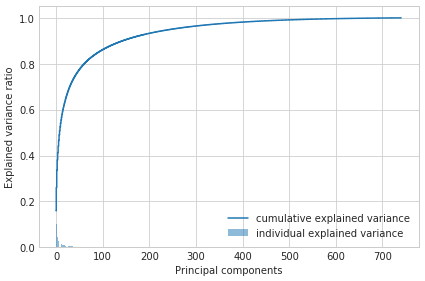

In [74]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(tsvd_var_ratios)), tsvd_var_ratios, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [75]:
# Create Function Calculating Number Of Components Required To Pass Threshold
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [76]:
# Run function
number_of_components = select_n_components(tsvd_var_ratios, 0.95)

In [77]:
number_of_components

248

In [78]:
truncated_opt_svd = TruncatedSVD(n_components=number_of_components, random_state=42)
transformed_X_train = truncated_opt_svd.fit_transform(X_train)
transformed_X_test = truncated_opt_svd.transform(X_test)

In [79]:
X = transformed_X_train
Y = train_data_labels

In [80]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data_labels)
                                               ,train_data_labels)

In [81]:
class_weight_dic = dict(enumerate(class_weight))

In [82]:
class_weight_dic

{0: 0.37236180904522614,
 1: 1.5278350515463917,
 2: 1.2453781512605042,
 3: 2.9058823529411764,
 4: 1.95}

In [48]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = number_of_components

cross_model = Sequential()
cross_model.add(Dense(128, input_dim=input_dim, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('relu'))
cross_model.add(Dropout(0.8))
#####################
# cross_model.add(Dense(32, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
# cross_model.add(BatchNormalization())
# cross_model.add(Activation('relu'))
# cross_model.add(Dropout(0.5))
#########################
cross_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('softmax'))

cross_model.compile(optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [49]:
for train, test in kfold.split(X, Y):
    # Fit the model
    cross_model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = cross_model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = cross_model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 99.74%
AVG Validation Acc : 98.24%
Validation precision - mean: 0.981945, stddev: 0.071213
Validation recall - mean: 0.981996, stddev: 0.064833
Validation f-score - mean: 0.981572, stddev: 0.066660
Confusion matrix:
[[7.832e+01 1.120e+00 1.600e-01 0.000e+00 0.000e+00]
 [7.600e-01 1.856e+01 8.000e-02 0.000e+00 0.000e+00]
 [4.000e-02 2.000e-01 2.352e+01 4.000e-02 0.000e+00]
 [0.000e+00 0.000e+00 4.000e-02 1.004e+01 1.200e-01]
 [4.000e-02 0.000e+00 4.000e-02 0.000e+00 1.512e+01]]


In [50]:
cvscores

[0.7549668874172185,
 0.912751677852349,
 0.9797297297297297,
 0.9863945578231292,
 0.9863013698630136,
 0.9801324503311258,
 1.0,
 0.9932432432432432,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9931506849315068,
 1.0,
 0.9932885906040269,
 1.0,
 1.0,
 0.9931506849315068,
 0.9933774834437086,
 0.9932885906040269,
 1.0,
 1.0,
 1.0]

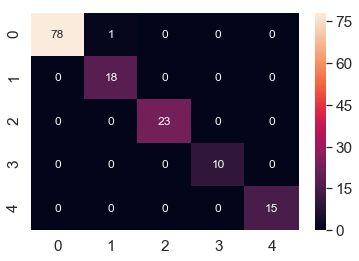

In [51]:
confusion_matrix_array = (sum(val_conmats).astype(float) / fold_counter)
new_confusion_matrix_array = []
for conf_sub_array in confusion_matrix_array:
    new_confusion_matrix_array.append([int(float(e)) for e in conf_sub_array])
        
df_cm = pd.DataFrame(new_confusion_matrix_array, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})# font size

In [52]:
# Save the model
cross_model.save('D:/retinal_data_set_visioncare/models/ensemble/densenet_deep_feature_with_SVD_dr.h5')

In [83]:
y_test = test_data_labels

In [84]:
# Returns a compiled model identical to the previous one
loaded_model = load_model('D:/retinal_data_set_visioncare/models/ensemble/densenet_deep_feature_with_SVD_dr.h5')

In [85]:
#Confution Matrix and Classification Report for testset
Y_pred_for_test = loaded_model.predict(transformed_X_test)
Y_pred_for_test = np.argmax(Y_pred_for_test, axis=1)
print('Confusion Matrix for testset')
confusion_matrix_for_testset = confusion_matrix(y_test, Y_pred_for_test)
print(confusion_matrix(y_test, Y_pred_for_test))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(y_test, Y_pred_for_test, target_names=target_names))

Confusion Matrix for testset
[[91  7  2  0  0]
 [ 0 19  0  0  0]
 [ 1  0 33  1  1]
 [ 0  0  2 17  1]
 [ 0  0  1  2 27]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.99      0.91      0.95       100
    mild-npdr       0.73      1.00      0.84        19
moderate-npdr       0.87      0.92      0.89        36
  severe-npdr       0.85      0.85      0.85        20
          pdr       0.93      0.90      0.92        30

  avg / total       0.92      0.91      0.91       205



In [86]:
# generate roc curve
n_classes = 5

# Plot linewidth.
lw = 2

#convert original class labels to the one-hot-encoding
y_test = np_utils.to_categorical(y_test, 5)

Y_test_pred = loaded_model.predict(transformed_X_test)
Y_test_predicted = np.argmax(Y_test_pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [87]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [88]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

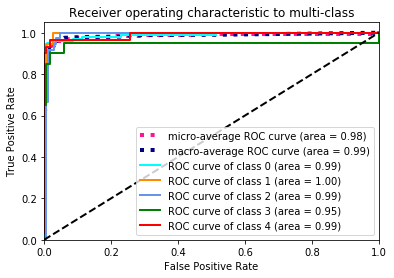

In [89]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

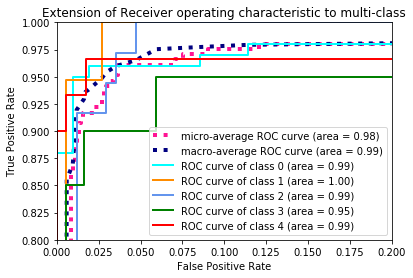

In [90]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()